# Context Dependent Generalization
This Demonstration compares performance of reinforcement learning models across seperate seperate tasks. Each Task consists of a series of trials with a single "goal" (self-absorbing state with positive reward) hidden in a grid world. An agent is randomly place in the grid at the start of a trial and has to reach the goal before proceeding to the next trial.


* Each trial is associated with a "context" and the state of the agent can be defined formally as a tuple of it's location in space and it's context:  
s = (x, y, c)
* Agent learns reward functions and a mapping function for each task. A mapping function is a relationship between primitive actions and cardinal movements (N, S, E, W), and is learned in place of a transition function. We assume an agent knowns cardinal movements

The agents are different only in how they utalize the context:
* Flat Agent: Assumes each context is independent
* Task Set Agent: Assumes contexts can be clustered together and clusters share both 1) Reward function and 2) Mapping
* Independent Clustering Agent: Assumes Reward functions and Mappings can be clustered indpendendly of each other based on their contexts


In [1]:
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns

from Agents import TaskSetAgent, IndependentClusterAgent, FlatAgent
from GridWorld import make_task

# Define a function to Simluate the Models
def simulate(agent_class, simulation_number, task_kwargs, agent_kwargs=None):
    _kwargs = copy.copy(task_kwargs)
    del _kwargs['list_goal_priors']
    task = make_task(**_kwargs)
    if agent_kwargs is not None:
        agent = agent_class(task, **agent_kwargs)
    else:
        agent = agent_class(task)
    agent.set_reward_prior(task_kwargs['list_goal_priors'])

    results = agent.generate()
    results['Simulation Number'] = [simulation_number] * len(results)
    results['Cumulative Steps Taken'] = results['n actions taken'].cumsum()

    return results

def simulate_all(n_sim, task_kwargs, agent_kwargs=None):
    resultsTS = pd.concat([simulate(TaskSetAgent, ii, task_kwargs) for ii in range(n_sim)])
    resultsIC = pd.concat([simulate(IndependentClusterAgent, ii, task_kwargs) for ii in range(n_sim)])
    resultsFL = pd.concat([simulate(FlatAgent, ii, task_kwargs) for ii in range(n_sim)])

    resultsTS['Model'] = ['Task Set'] * len(resultsTS)
    resultsIC['Model'] = ['Independent Clustering'] * len(resultsIC)
    resultsFL['Model'] = ['Flat Agent'] * len(resultsFL)
    return pd.concat([resultsTS, resultsIC, resultsFL])

### Task 1
The first set of simulations are on a set of 8x8 gridworlds. There are six contexts with
a total of 4 goal locations (one at each corner) and 2 mappings. None of the contexts share a goal and a mapping, but generalization is still possible between them.

In [2]:
# define all of the task parameters
grid_world_size = (6, 6)

# define mapping between primitive action (a in [0, 1]) and cardinal movements
# (left, right, up down)
map_0 = {0: u'left', 1: u'up', 2: u'down', 3: u'right'}
map_1 = {4: u'up', 5: u'left', 6: u'right', 7: u'down'}

# define the mappings for each context, where the ith mapping belongs the ith context
context_maps = [map_0, map_0, map_0, map_0, map_1, map_1]

# define goal locations 
goal_0 = (0, 0)
goal_1 = (0, 5)
goal_2 = (5, 0)
goal_3 = (5, 5)

# define the goal location for each context, where the ith goal belongs the ith context
context_goals = [goal_0, goal_1, goal_2, goal_3, goal_0, goal_3]

# randomly start the agent somewhere in the middle of the map
start_locations = [(x, y) for x in range(1, 5) for y in range(1, 5)]

context_balance = [2, 2, 6, 6, 4, 4]

# the hazard rate determines a degree of auto correlation in the context orders. This is
# useful in human studies. The hazard rates is the defined by the probability of a 
# context change after i repeats is f(i)
hazard_rates = [0.5, 0.67, 0.67, 0.75, 1.0]

# we include a prior in the reward function over the goal locations
list_goal_priors = [(0, 0), (0, 5), (5, 0), (5, 5)]

task_kwargs = dict(context_balance=context_balance, context_goals=context_goals, 
                   context_maps=context_maps, hazard_rates=hazard_rates,
                   start_locations=start_locations, grid_world_size=grid_world_size,
                   list_goal_priors=list_goal_priors)    

Now, we simulate each model 100 times and plot the cumulative number of steps taken across 
trials. In the task, the agent must reach the goal (an absorbing state with positive reward)
to advance to the next trial. Lower cumulative steps taken indicated faster learning.

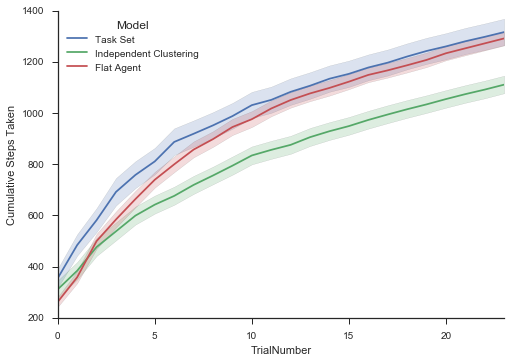

In [3]:
n_sim = 100

results = simulate_all(n_sim, task_kwargs)

# define the parameters to plot the results
tsplot_kwargs = dict(
    time='TrialNumber',
    value='Cumulative Steps Taken',
    data=results[results['In goal']], 
    unit='Simulation Number',
    condition='Model',
)

with sns.axes_style('ticks'):
    sns.tsplot(**tsplot_kwargs)
    sns.despine()

We can see in this demonstration the agent that clusters mappings and rewards independently is meaningfully faster. We can also see the Task Set agent, which generalizes mappings and rewards together, has a performance penalty vs the Flat agent. In this enviornment, the Task Set agent searches the space less efficiently.

*note: The performance of the agents is stochastic, but in general, this is what we see.*



### Task 2:
We can also define other task enviornments. Here, we define the same task but on a gridworld with 3x3 grid. In the smaller gridworld, the generalization advantage is not as meaningful as the exploration problem is easier, allowing the "Flat" learner (no context based generalization) to perform roughly as well.

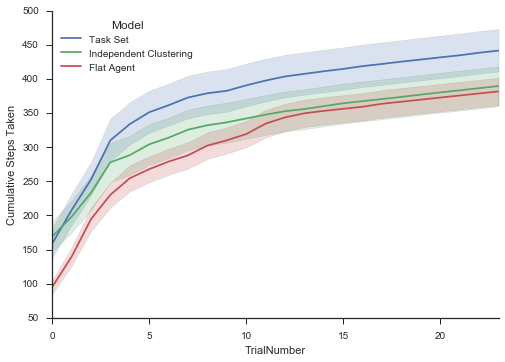

In [4]:
# define all of the task parameters here
grid_world_size = (3, 3)

goal_0 = (0, 0)
goal_1 = (0, 2)
goal_2 = (2, 0)
goal_3 = (2, 2)
context_goals = [goal_0, goal_1, goal_2, goal_3, goal_0, goal_3]

# randomly start the agent somewhere in the middle of the map
start_locations = [(1, 1)]

list_goal_priors = [(0, 0), (0, 2), (2, 0), (2, 2)]

task_kwargs = dict(context_balance=context_balance, context_goals=context_goals, 
                   context_maps=context_maps, hazard_rates=hazard_rates,
                   start_locations=start_locations, grid_world_size=grid_world_size,
                   list_goal_priors=list_goal_priors)

# simulate the agents
results = simulate_all(n_sim, task_kwargs)

tsplot_kwargs['data'] = results[results['In goal']]
with sns.axes_style('ticks'):
    sns.tsplot(**tsplot_kwargs)
    sns.despine()

### Task 3:
Here, we show a task where it is useful to generalize contexts as a whole. Each context that shares a reward function with another context also shares its mapping. As such, generalizing the context as a whole is useful.

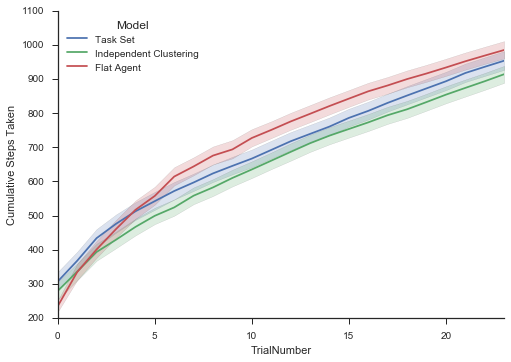

In [5]:
# define all of the task parameters
grid_world_size = (6, 6)

# define the mappings for each context, where the ith mapping belongs the ith context
context_maps = [map_0, map_0, map_0, map_1, map_1, map_1]

# define goal locations 
goal_0 = (0, 0)
goal_1 = (0, 5)
goal_2 = (5, 0)
goal_3 = (5, 5)
# define the goal location for each context, where the ith goal belongs the ith context
context_goals = [goal_0, goal_0, goal_0, goal_3, goal_3, goal_3]

start_locations = [(x, y) for x in range(1, 5) for y in range(1, 5)]

context_balance = [4, 4, 4, 4, 4, 4]

list_goal_priors = [(0, 0), (0, 5), (5, 0), (5, 5)]

task_kwargs = dict(context_balance=context_balance, context_goals=context_goals, 
                   context_maps=context_maps, hazard_rates=hazard_rates,
                   start_locations=start_locations, grid_world_size=grid_world_size,
                   list_goal_priors=list_goal_priors)

results = simulate_all(n_sim, task_kwargs)

tsplot_kwargs['data'] = results[results['In goal']]
with sns.axes_style('ticks'):
    sns.tsplot(**tsplot_kwargs)
    sns.despine()

Here, we can see that the Task Set model, which assume context clusters share both reward functions and mappings, outperforms the flat agent. We can also construct enviornments in which there is a substantial benefit to this type of generalization. However, independently clustering provides a more flexable method that does not suffer the same performance penalties as the Task Set agent. 